### Training a Regularized Logistic Regression model for Machine Failure Prediction using NumPy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import pickle as pkl

In [6]:
df = pd.read_csv('data/data.csv')

In [8]:
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [9]:
df.describe()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,306.381356,3.727754,4.325212,2.939619,5.394068,2.842161,47.043432,4.565678,16.331568,0.416314
std,1082.606745,2.677235,1.438436,1.383725,1.269349,2.273337,16.423130,1.599287,5.974781,0.493208
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,14.000000,0.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000,0.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000,1.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB


In [11]:
df.duplicated().sum()

1

In [12]:
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [13]:
df.shape

(944, 10)

In [14]:
df.isna().sum()

footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64

In [15]:
df.drop_duplicates(inplace=True)

### Statistics

Numerical and Categorical Columns separation 

In [24]:
numerical_columns = list(df.columns[df.dtypes!='object'])
categorical_columns = list(df.columns[df.dtypes=='object'])
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature', 'fail']
Categorical Columns : []


### Numerical Columns Description

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
footfall,943.0,306.673383,1083.144024,0.0,1.0,22.0,110.0,7300.0
tempMode,943.0,3.726405,2.678334,0.0,1.0,3.0,7.0,7.0
AQ,943.0,4.326617,1.438551,1.0,3.0,4.0,6.0,7.0
USS,943.0,2.939555,1.384458,1.0,2.0,3.0,4.0,7.0
CS,943.0,5.393425,1.269869,1.0,5.0,6.0,6.0,7.0
VOC,943.0,2.844115,2.273751,0.0,1.0,2.0,5.0,6.0
RP,943.0,47.042418,16.431816,19.0,34.0,44.0,58.0,91.0
IP,943.0,4.564157,1.599452,1.0,3.0,4.0,6.0,7.0
Temperature,943.0,16.326617,5.976014,1.0,14.0,17.0,21.0,24.0
fail,943.0,0.416755,0.493283,0.0,0.0,0.0,1.0,1.0


### All Unique values in DataSet

In [26]:
df.nunique()

footfall       99
tempMode        8
AQ              7
USS             7
CS              7
VOC             7
RP             71
IP              7
Temperature    24
fail            2
dtype: int64

### Finding the continuous and discrete feature in Numerical features

In [31]:
numerical_feat=[feature for feature in df.columns if df[feature].dtype!='o']
numerical_feat

['footfall',
 'tempMode',
 'AQ',
 'USS',
 'CS',
 'VOC',
 'RP',
 'IP',
 'Temperature',
 'fail']

In [32]:
continuous_feature=[]
discrete_feature=[]
for feature in numerical_feat:
    if len(df[feature].unique())<=10:
        discrete_feature.append(feature)
    else:
        continuous_feature.append(feature)
continuous_feature,discrete_feature

(['footfall', 'RP', 'Temperature'],
 ['tempMode', 'AQ', 'USS', 'CS', 'VOC', 'IP', 'fail'])

In [33]:
for feature in df.columns:
    print(f"{feature} contain {len(df[feature].unique())} unique values")

footfall contain 99 unique values
tempMode contain 8 unique values
AQ contain 7 unique values
USS contain 7 unique values
CS contain 7 unique values
VOC contain 7 unique values
RP contain 71 unique values
IP contain 7 unique values
Temperature contain 24 unique values
fail contain 2 unique values


Finding relationship discrete feature and target variable

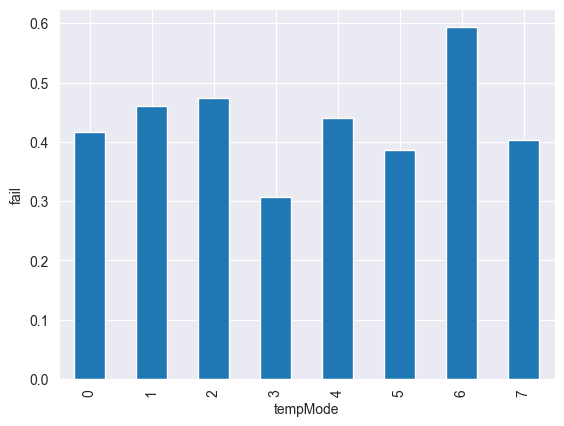

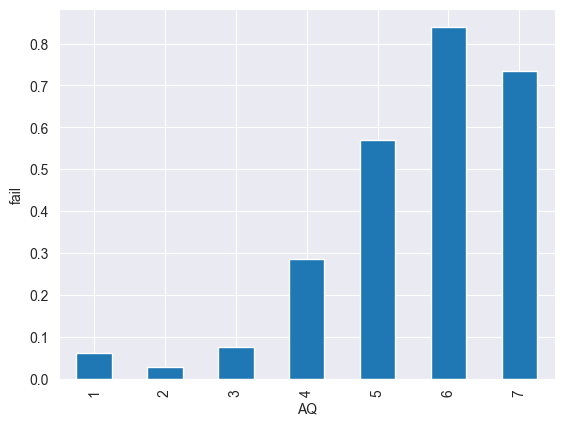

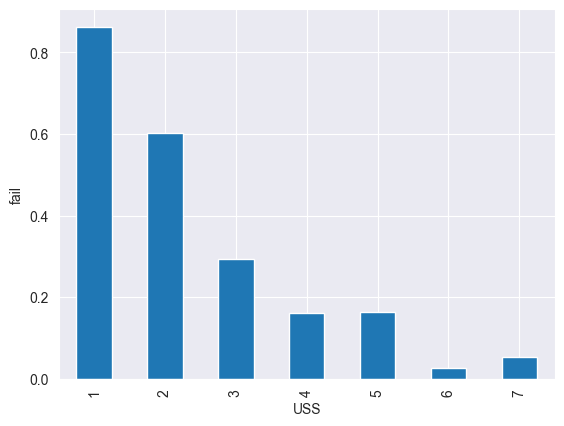

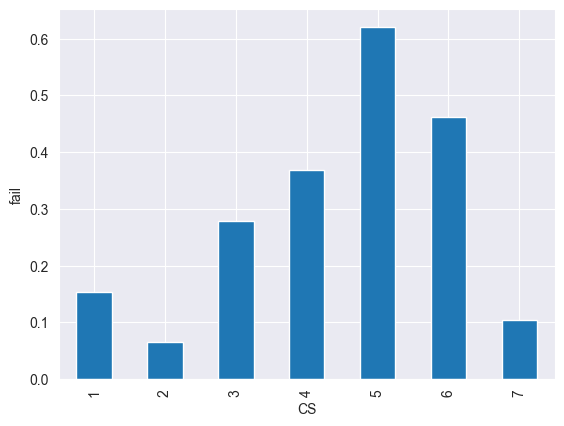

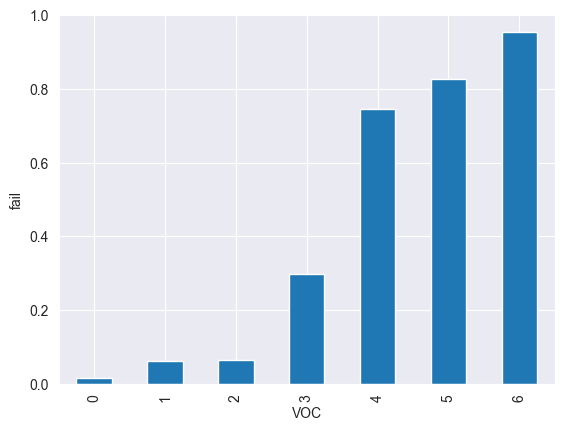

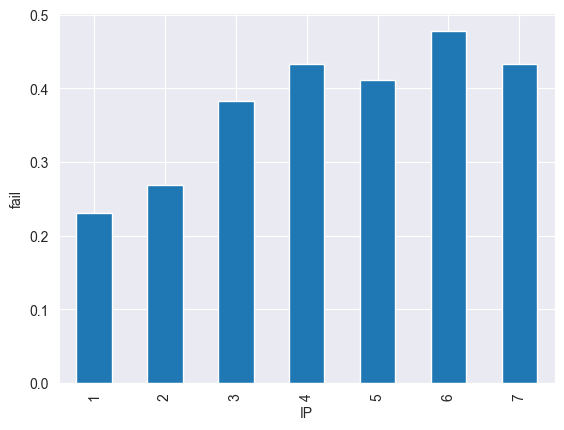

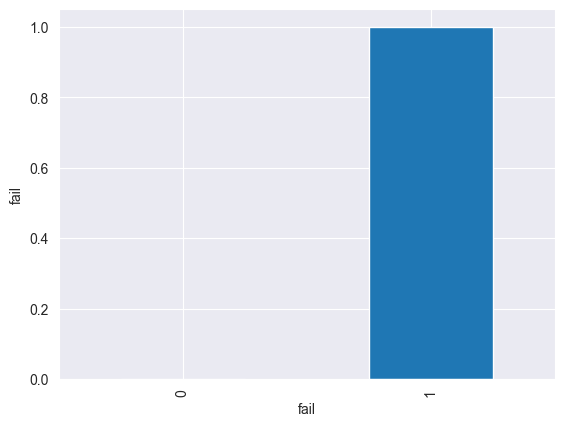

In [34]:
for feature in discrete_feature:
    df.groupby(feature)['fail'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('fail')
    plt.show()

Finding the relationship continuous feature and target variable

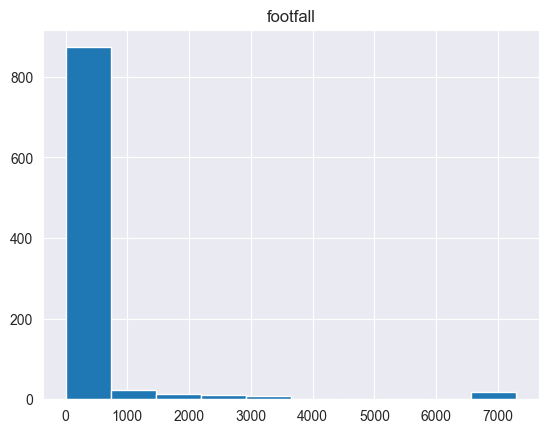

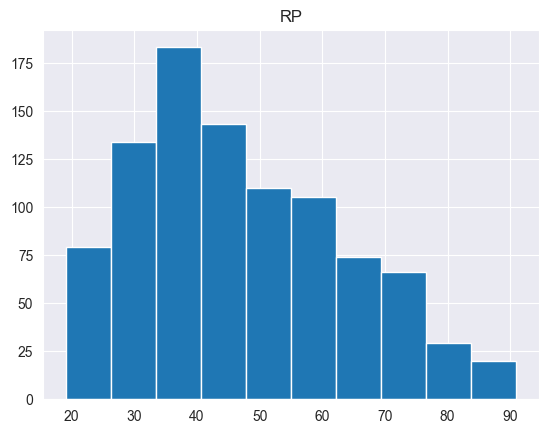

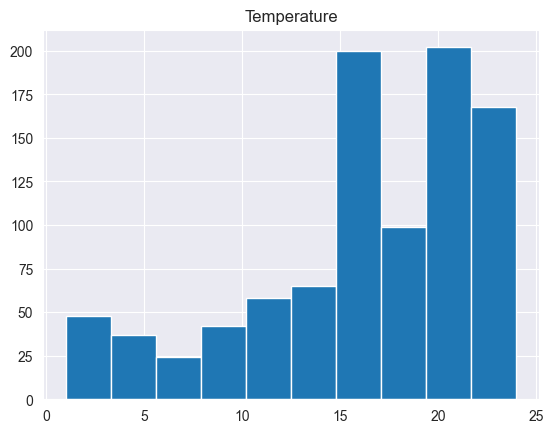

In [35]:
for feature in continuous_feature:
    df[feature].hist()
    plt.title(feature)
    plt.show()

In [36]:
for feature in continuous_feature:
    df[feature]=np.log(df[feature]+1)

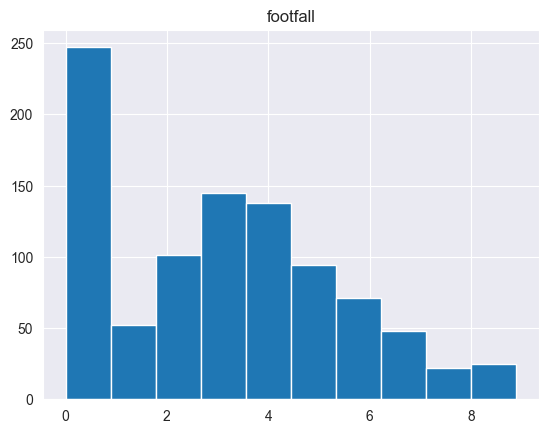

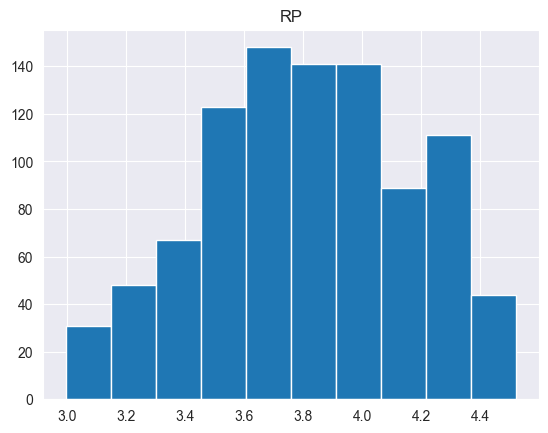

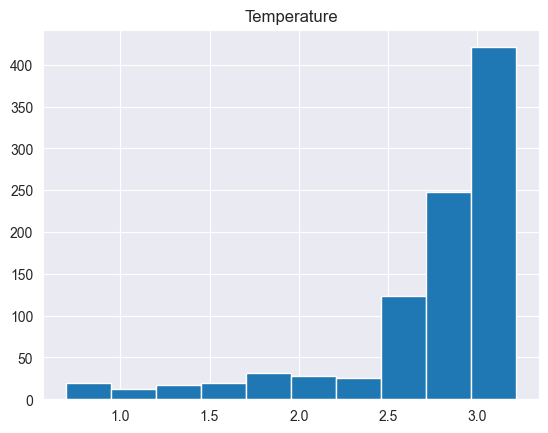

In [37]:
for feature in continuous_feature:
    df[feature].hist()
    plt.title(feature)
    plt.show()

### Finding Outliers

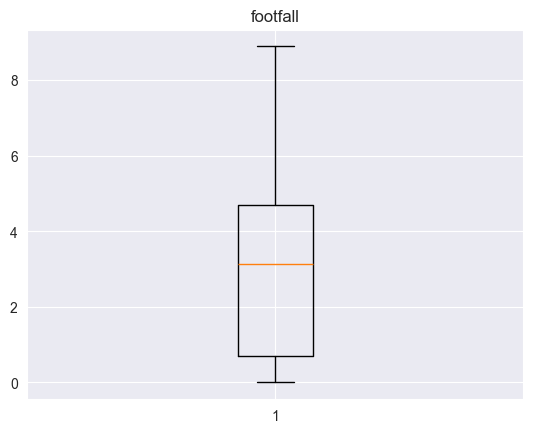

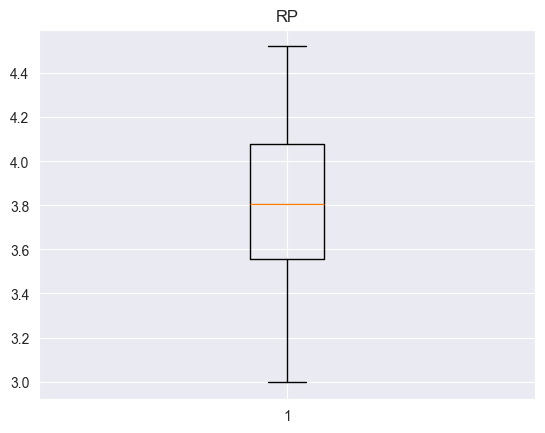

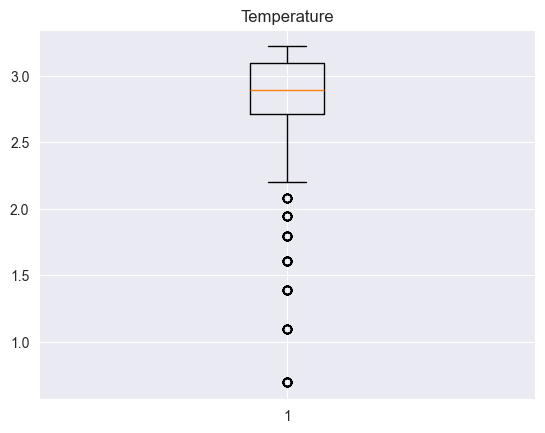

In [38]:
for feature in continuous_feature:
    plt.boxplot(df[feature])
    plt.title(feature)
    plt.show()

In [39]:
df[df['Temperature']<2.3]

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0.000000,7,7,1,6,6,3.610918,3,0.693147,1
1,5.252273,1,3,3,5,1,3.044522,4,0.693147,0
2,3.465736,7,2,2,6,1,3.218876,6,0.693147,0
3,4.430817,4,3,4,5,1,3.367296,6,0.693147,0
4,6.463029,7,5,6,4,0,4.234107,6,0.693147,0
...,...,...,...,...,...,...,...,...,...,...
121,5.141664,2,4,2,6,6,3.091042,3,2.197225,1
122,6.463029,7,3,6,4,0,4.025352,5,2.197225,0
123,2.302585,4,6,3,6,6,3.433987,6,2.197225,1
124,0.000000,4,5,3,6,4,4.343805,7,2.197225,1


In [40]:
m=df['Temperature'].mean()

In [41]:
outliers = df['Temperature'] < 2.3
df.loc[outliers, 'Temperature'] = m

{'whiskers': [<matplotlib.lines.Line2D at 0x29b2af591f0>,
 'caps': [<matplotlib.lines.Line2D at 0x29b2af59cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29b2af58fe0>],
 'medians': [<matplotlib.lines.Line2D at 0x29b2af58200>],
 'fliers': [<matplotlib.lines.Line2D at 0x29b2af58f20>],
 'means': []}

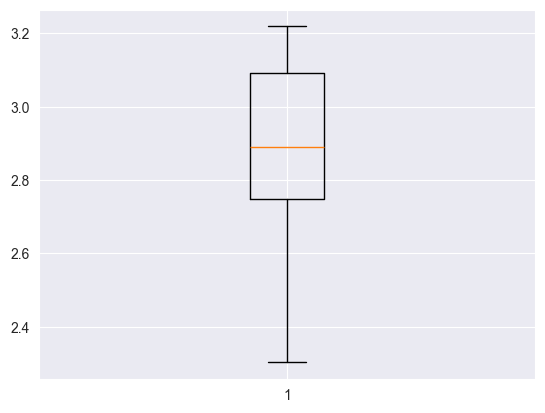

In [42]:
plt.boxplot(df['Temperature'])

Feature Engineering

In [43]:
df[df['tempMode']==0]

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
9,7.937732,0,3,3,7,0,3.688879,3,2.749497,0
10,7.378384,0,3,2,4,4,3.295837,2,2.749497,0
21,5.252273,0,2,4,6,2,3.044522,4,2.749497,0
24,2.995732,0,4,2,2,1,3.828641,3,2.749497,0
30,5.860786,0,3,4,7,2,3.295837,2,2.749497,0
...,...,...,...,...,...,...,...,...,...,...
912,2.944439,0,2,4,6,1,3.951244,7,3.218876,0
915,2.302585,0,6,2,6,6,3.526361,6,3.218876,1
922,3.526361,0,4,3,6,2,3.526361,7,3.218876,0
925,0.000000,0,3,4,4,0,3.891820,6,3.218876,0


### Model Training with and without removing tempMode==0 rows

In [44]:
from sklearn.model_selection import train_test_split
X=df.drop('fail',axis=1)
Y=df['fail']

In [45]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
X_train.shape,X_test.shape

((754, 9), (189, 9))

In [46]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,Y_train)

LogisticRegression()

In [47]:
lr.score(X_test,Y_test)

0.9365079365079365

In [48]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=3000,max_depth=15,max_features='sqrt')
forest.fit(X_train,Y_train)

RandomForestClassifier(max_depth=15, n_estimators=3000)

In [51]:
forest.score(X_test,Y_test)

0.8994708994708994

In [52]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(X_train)
X_train_scaled=sc.transform(X_train)
X_test_scaled=sc.transform(X_test)

In [53]:
X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=X_test.columns)

In [54]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=3000)
forest.fit(X_train_scaled,Y_train)

RandomForestClassifier(n_estimators=3000)

In [55]:
lr.score(X_test_scaled,Y_test)

0.91005291005291

In [56]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_scaled,Y_train)

LogisticRegression()

In [57]:
lr.score(X_test_scaled,Y_test)

0.9365079365079365

In [61]:
from sklearn.model_selection import GridSearchCV
forest=RandomForestClassifier()
grid_perm={
    'n_estimators':[1000,2000,3000],
    'min_samples_split':[2,4],
    'max_depth':[None,4,8]
}
grid=GridSearchCV(forest,grid_perm,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 4, 8], 'min_samples_split': [2, 4],
                         'n_estimators': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [62]:
best_forest=grid.best_estimator_

In [63]:
best_forest.score(X_test,Y_test)

0.8994708994708994

In [64]:
best_forest

RandomForestClassifier(n_estimators=1000)

In [65]:
from sklearn.svm import SVC
cla=SVC(kernel='linear')
cla.fit(X_train,Y_train)

SVC(kernel='linear')

In [66]:
cla.score(X_test,Y_test)

0.9153439153439153

In [67]:
from sklearn.neighbors import KNeighborsClassifier
knc=KNeighborsClassifier(n_neighbors=3)
knc.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=3)

In [68]:
knc.score(X_test,Y_test)

0.9047619047619048

In [69]:
df=df[df['tempMode']!=0]

In [70]:
from sklearn.model_selection import train_test_split
X=df.drop('fail',axis=1)
Y=df['fail']

In [71]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.11,random_state=0)
X_train.shape,X_test.shape

((695, 9), (87, 9))

In [72]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,Y_train)

LogisticRegression()

In [73]:
lr.score(X_test,Y_test)

0.9425287356321839

In [74]:
from sklearn.svm import SVC
cla=SVC(kernel='linear')
cla.fit(X_train,Y_train)

SVC(kernel='linear')

In [75]:
cla.score(X_test,Y_test)

0.9425287356321839